In [42]:
#%pip install hyperspectral_gta_data

In [43]:
# Common useful packages
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import copy
import spectral

# module that is useful for reloading packages
import importlib

# Scripts associated with the SML4SI textbook
import hyperspectral_gta_data as hsi_data
import scripts_M2 as sm2

# Part 1: Open the image and load the data as a numpy array.

In [44]:
# To download and use the Washington DC image:
hsi_data.download('WashingtonDC')
fname = 'spectral_images/WashingtonDC_Ref_156bands/WashingtonDC_Ref_156bands'

# To download and use the polymers image:
# hsi_data.download('MicroscenePolymers')
# fname = 'Book Modules\spectral_images\Microscene_Polymers\reflectance_image_polymers

In [45]:
# Open the image and read into an array
im = spectral.envi.open(fname+'.hdr', fname)
wl = np.asarray(im.bands.centers)
# Load the image into memory
imArr = im.load()
print(f'Shape of ImArr = {imArr.shape}')

# To work with the data, we usually reshape the data from an image (# rows, # cols, # bands)
# into a standard (# observations, # features) array as (# pixels, # bands)
imList = np.reshape(imArr, (im.nrows*im.ncols, im.nbands))
print(f'Shape of imList = {imList.shape}')

Shape of ImArr = (1280, 307, 156)
Shape of imList = (392960, 156)


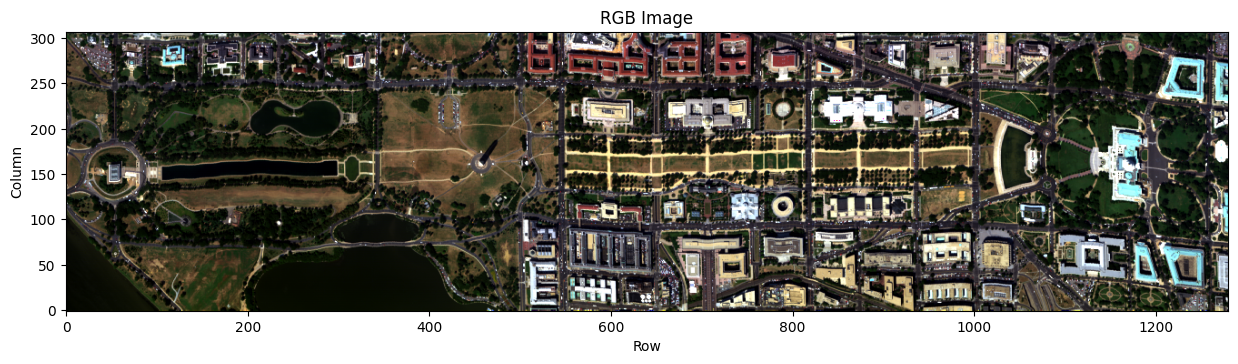

In [46]:
sm2.display_RGB(imArr, wl, rotate=True)
plt.title('RGB Image');

# PART 2: Viewing a scatterplot of the hyperspectral image.

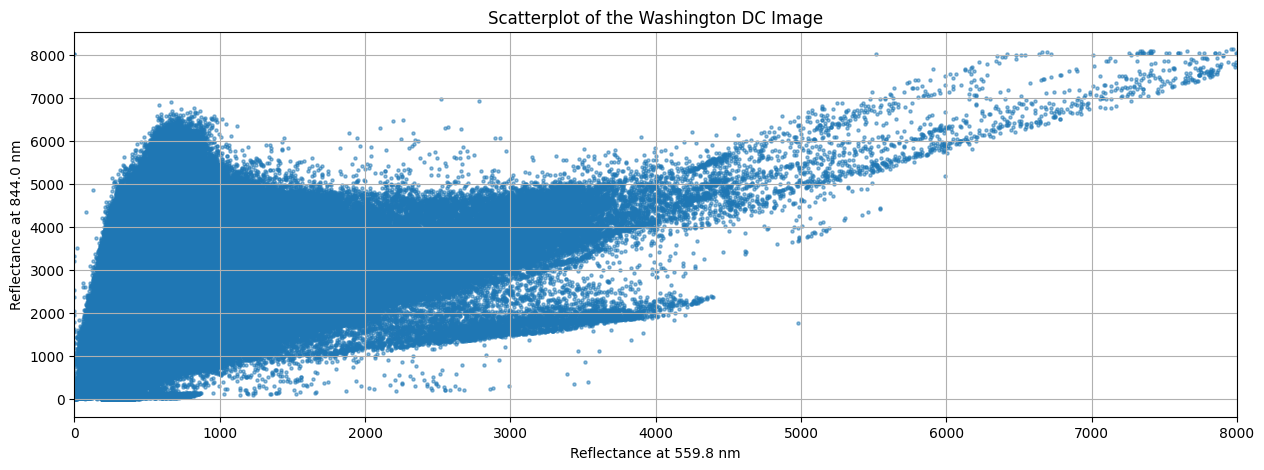

In [47]:
# Create a scatterplot of the data
i1 = 30
i2 = 60

plt.figure(figsize=(15,5))
plt.scatter(imList[:,i1], imList[:,i2], s=5, alpha=0.5);
plt.xlim(0,8000)
plt.grid(True)
plt.xlabel(f'Reflectance at {wl[i1]:.1f} nm')
plt.ylabel(f'Reflectance at {wl[i2]:.1f} nm')
plt.title('Scatterplot of the Washington DC Image');

# Part 3: Clustering using K-Means

Documentation on K Means clustering using sklearn in Python: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

A discussion of 11 clustering algorithms with Python implementations is provided in: https://scikit-learn.org/stable/modules/clustering.html

In [48]:
# parameter
#dist_type = 'Euclidean'
dist_type = 'Correlation'

k = 4

# Step 0:
nRows, nCols, nBands = imArr.shape
nPix = nRows*nCols
class_index = np.random.randint(low=0, high=k, size=nPix)

In [49]:
# Crteate a array of normalized (subratct mean, divide by standard deviation) spectra
imListNormed = copy.copy(imList)
imListNormed.shape
imList_mu = np.mean(imList, axis=1)
for j in range(nBands):
    imListNormed[:,j] = imListNormed[:,j] - imList_mu
imList_stdev = np.std(imList, axis=1)
for j in range(nBands):
    imListNormed[:,j] = imListNormed[:,j] / imList_stdev

In [50]:
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#scaler.fit(imList)
#standardized_dataset = scaler.transform(imList)

Get the sum of the differences between a pixel's reflectance values and its mean (i.e., between each reflectance value of the pixel/spectrum and its (the pixel's/spectrum's) mean)
Get the sum of the differences between the class mean's reflectance values and its overall mean

Get the covariance by multiplying these together

In [51]:
# Step 1: Compute Class Means
class_means = np.zeros((k,nBands))
for i in range(k):
    idx = np.where(class_index==i)
    spectra_for_this_class = np.squeeze(imList[idx,:])
    class_means[i,:] = np.mean(spectra_for_this_class, axis=0)

# Step 2: Re-assign Class Labels
if dist_type == 'Euclidean':
    
    distance_to_mean = np.zeros((nPix,k))
    for i_cls in range(k):    
        imListTemp = copy.copy(imList)
        for j in range(nBands):
            imListTemp[:,j] = imListTemp[:,j] - class_means[i_cls,j]
        distance_to_mean[:,i_cls] = np.sum(imListTemp**2, axis=1)
    class_index = np.argmin(distance_to_mean, axis=1)
    
else:
    
    correlation_to_mean = np.zeros((nPix,k))
    for i_cls in range(k): 
        class_mean = class_means[i_cls,:]
        class_mean_Normed = (class_mean - np.mean(class_mean)) / np.std(class_mean)
        correlation_to_mean[:,i_cls] = (1/nBands)*np.matmul(imListNormed,class_mean_Normed)
    class_index = np.argmax(correlation_to_mean, axis=1)
    


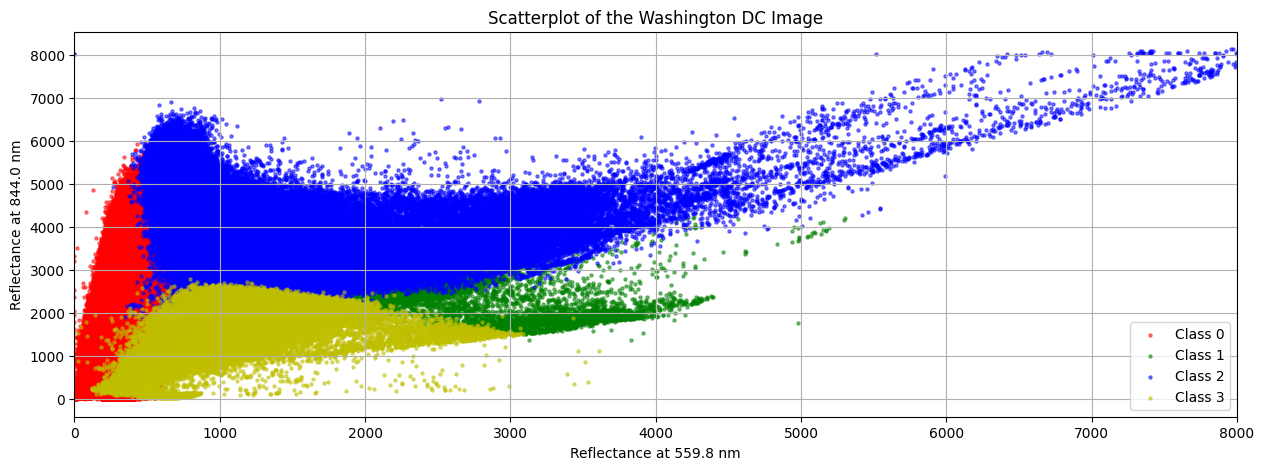

In [52]:
plt.figure(figsize=(15,5))
colors = ['r','g','b','y']
for i in range(k): 
    idx = np.where(class_index==i)
    S = np.squeeze(imList[idx,:])
    plt.scatter(S[:,i1], S[:,i2], c=colors[i], s=5, alpha=0.5, label=f'Class {i}');
plt.xlim(0,8000)
plt.grid(True)
plt.xlabel(f'Reflectance at {wl[i1]:.1f} nm')
plt.ylabel(f'Reflectance at {wl[i2]:.1f} nm')
plt.title('Scatterplot of the Washington DC Image');
plt.legend()

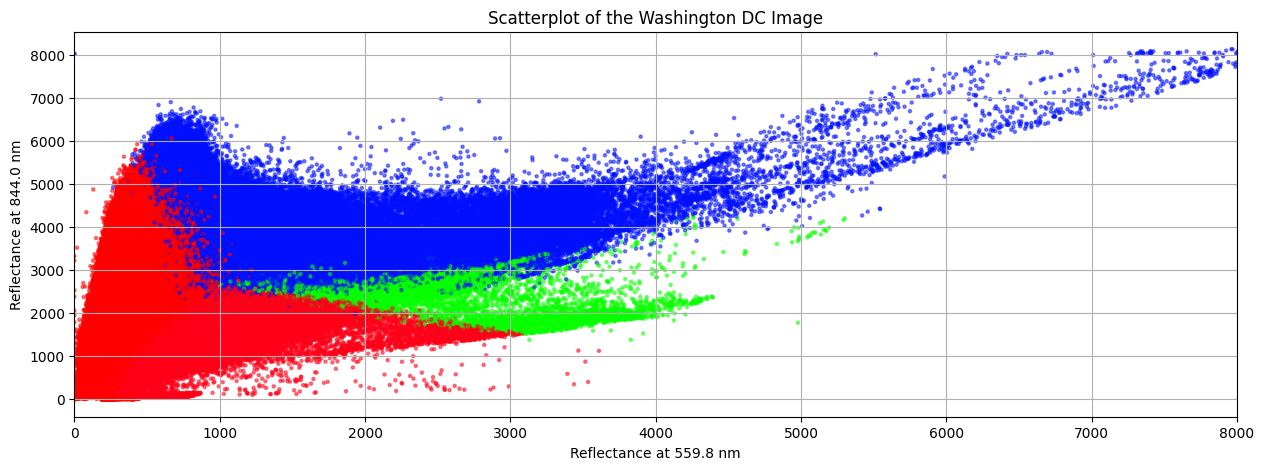

In [53]:
plt.figure(figsize=(15,5))
plt.scatter(imList[:,i1], imList[:,i2], c=class_index, s=5, alpha=0.5, cmap='hsv');
plt.xlim(0,8000)
plt.grid(True)
plt.xlabel(f'Reflectance at {wl[i1]:.1f} nm')
plt.ylabel(f'Reflectance at {wl[i2]:.1f} nm')
plt.title('Scatterplot of the Washington DC Image');

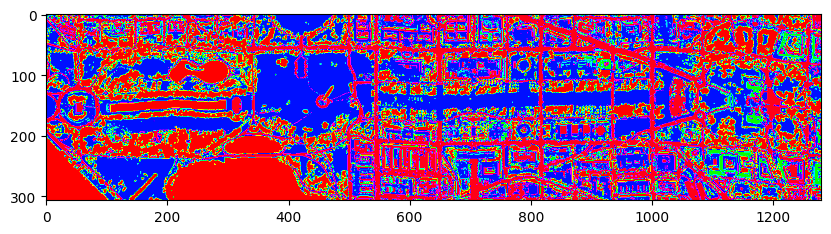

In [55]:
plt.figure(figsize=(10,5))
class_image = np.reshape(class_index, (nRows,nCols))
plt.imshow(np.rot90(class_image), cmap='hsv')